In [1]:
# General
import scipy as sci
import numpy as np
import pandas as pd
import logging
import time
import pickle
from itertools import chain
import anndata as ad
import gc # Free memory #gc.collect()

# # Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib import rcParams
from matplotlib import cm
import seaborn as sb
#from plotnine import *

# # Analysis
import scanpy as sc
import scanpy.external as sce
import muon

In [2]:
adata = sc.read("/lustre/groups/ml01/workspace/moscot_paper/pancreas_revision/adata_annotation_4.h5ad")

/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [3]:
def adapt_cell_type(x):
    if x['leiden_sub12'] == "15,0":
        return "Eps/Delta progenitors"
    if x['leiden_sub12'] == "15,4":
        return "Ngn3 high"
    if x['cell_type'] == "Eps/Delta progenitors":
        return "Eps. progenitors"
    return x['cell_type']
adata.obs["cell_type"] = adata.obs.apply(adapt_cell_type, axis=1).astype("category")

In [4]:
adata.obs["cell_type_refined"] = adata.obs["cell_type"].copy()
adata.obs["cell_type"] = adata.obs.apply(lambda x: "Fev+ Delta" if x["cell_type"] in ("Fev+ Delta,0", "Fev+ Delta,1") else x["cell_type"], axis=1)

In [5]:
mudata = muon.read("/lustre/groups/ml01/workspace/moscot_paper/pancreas_revision/mudata_with_embeddings_before_clustering.h5mu")

/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [6]:
mudata.obs["cell_type"] = adata.obs["cell_type"]
mudata.obs["cell_type_refined"] = adata.obs["cell_type_refined"]

In [7]:
mudata["rna"].obs["cell_type"] = adata.obs["cell_type"]
mudata["atac"].obs["cell_type"] = adata.obs["cell_type"]
mudata["rna"].obs["cell_type_refined"] = adata.obs["cell_type_refined"]
mudata["atac"].obs["cell_type_refined"] = adata.obs["cell_type_refined"]

In [8]:
mudata = mudata[~mudata.obs["cell_type"].isin(("22", "23"))]

In [9]:
mudata.obs["cell_type"].value_counts()

Ductal                   3717
Ngn3 high                3586
Mat. Acinar              3124
Imm. Acinar              2198
Prlf. Ductal             1920
Ngn3 low                 1609
Fev+ Beta                1439
Fev+                     1298
Alpha                    1159
Beta                      936
Fev+ Alpha                333
Fev+ Delta                296
Epsilon                   290
Eps/Delta progenitors     284
Delta                     239
Ngn3 high cycling         176
Name: cell_type, dtype: int64

In [17]:
adata_gex = mudata["rna"].copy()

In [18]:
adata_gex.X = adata_gex.layers["raw_counts"]

/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


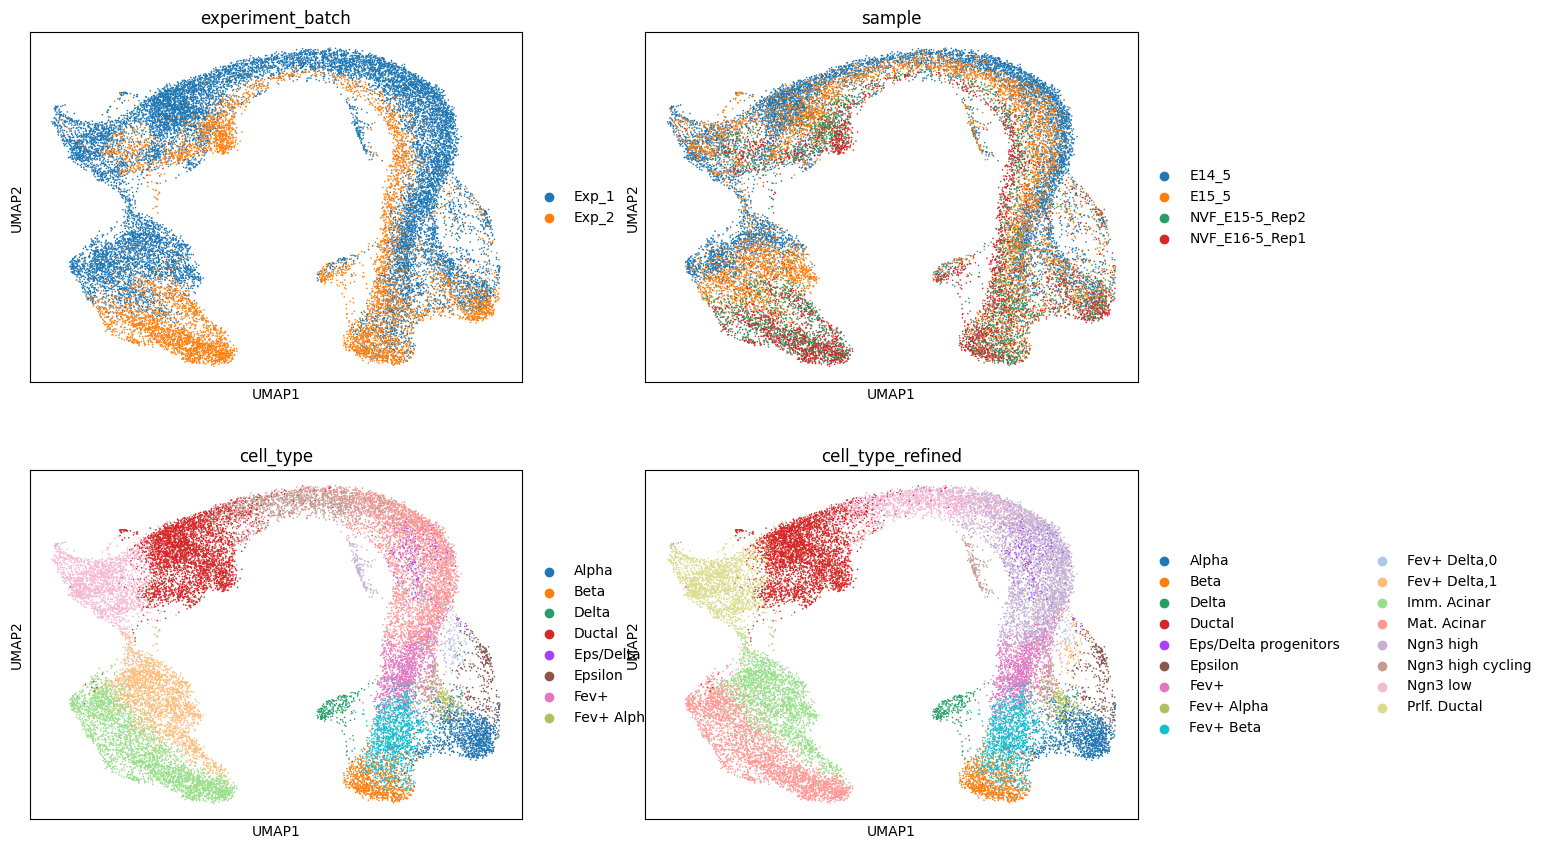

In [19]:
sc.pp.normalize_total(adata_gex)
sc.pp.log1p(adata_gex)
sc.pp.pca(adata_gex)
sc.pp.neighbors(adata_gex)
sc.tl.umap(adata_gex)
sc.pl.umap(adata_gex, color=["experiment_batch", "sample", "cell_type", "cell_type_refined"], ncols=2)

/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


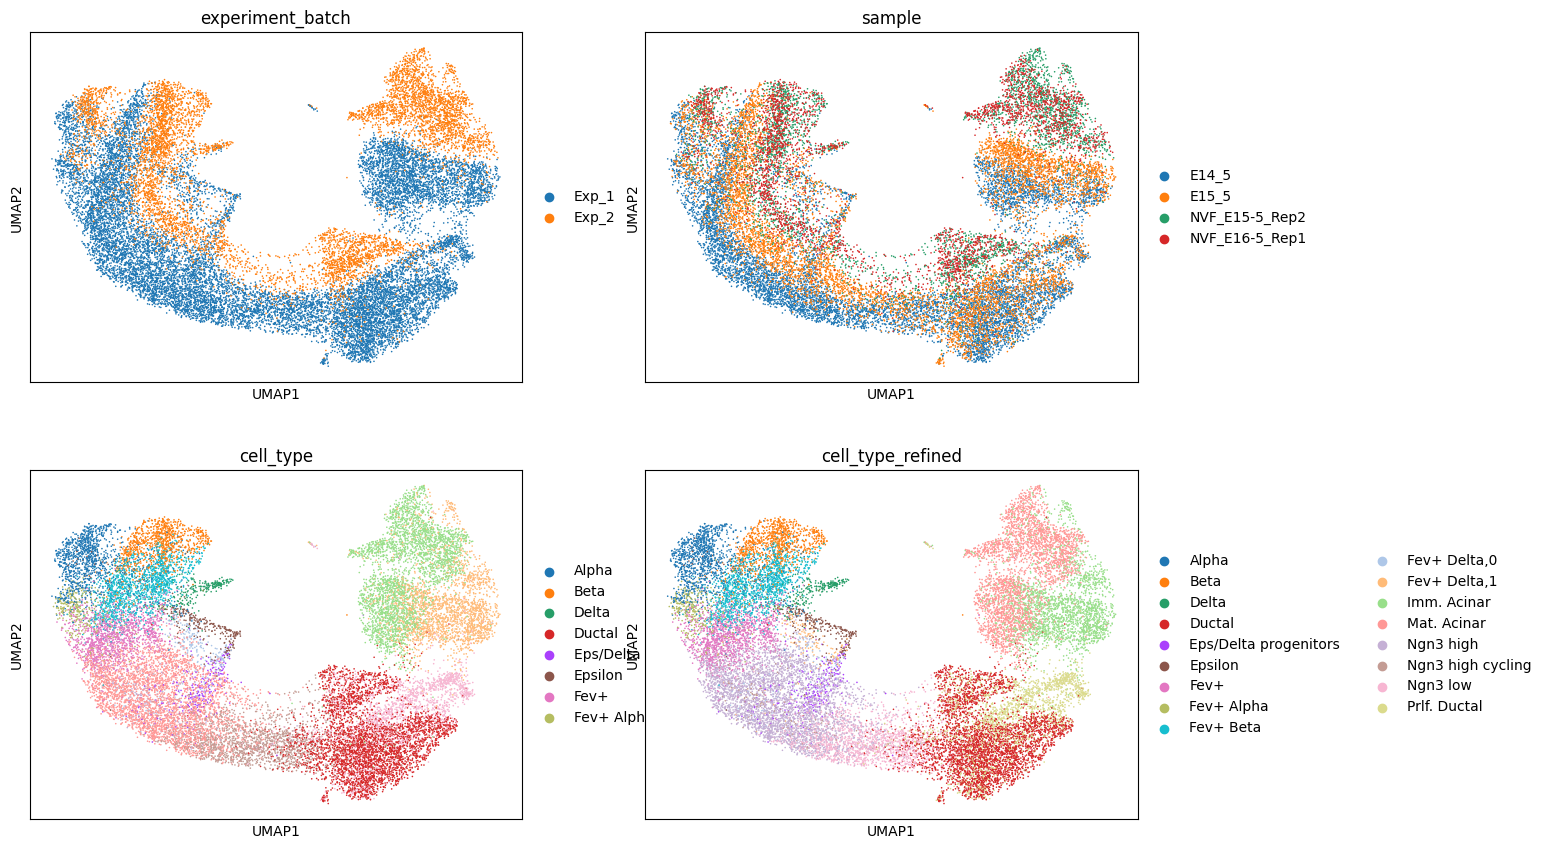

In [20]:
adata_atac = mudata["atac"].copy()
adata_atac.X = adata_atac.layers["atac_raw_counts"]
muon.atac.pp.tfidf(adata_atac, scale_factor=1e4)
muon.atac.tl.lsi(adata_atac)
to_keep = list(set(range(adata_atac.obsm["X_lsi"].shape[1])) - {0, 6})
adata_atac.obsm["X_lsi_red"] = adata_atac.obsm["X_lsi"][:,to_keep]
sc.pp.neighbors(adata_atac, use_rep="X_lsi_red")
sc.tl.umap(adata_atac)
sc.pl.umap(adata_atac,color=["experiment_batch", "sample", "cell_type", "cell_type_refined"], ncols=2)

In [21]:
color_dict = {'Prlf. Ductal': '#f7b6d2', 'Ductal': '#d62728', 'Imm. Acinar': '#ffeb3b', 'Mat. Acinar': '#98df8a',
    'Alpha': '#1f77b4', 'Beta': '#ff7f0e', 'Delta': '#279e68', 'Eps/Delta progenitors': '#aa40fc', 'Epsilon': '#8c564b',
       'Fev+': '#e377c2', 'Fev+ Alpha': '#b5bd61', 'Fev+ Beta': '#42f5ec', 'Fev+ Delta': '#aec7e8', 'Fev+ Delta,0': '#17becf', 'Fev+ Delta,1':'#98df8a',
      'Ngn3 high cycling': '#adf542',
        'Ngn3 high,0': '#ff9896', 'Ngn3 high': '#ff9896', 'Ngn3 high,1':'#f0b98d', 'Ngn3 low': '#c5b0d5'
}

In [26]:
mudata.obs["cell_type"] = mudata.obs["cell_type"].astype("category").cat.remove_unused_categories()
mudata["rna"].obs["cell_type"] = mudata["rna"].obs["cell_type"].astype("category").cat.remove_unused_categories()
mudata["atac"].obs["cell_type"] = mudata["atac"].obs["cell_type"].astype("category").cat.remove_unused_categories()

mudata.obs["cell_type_refined"] = mudata.obs["cell_type_refined"].astype("category").cat.remove_unused_categories()
mudata["rna"].obs["cell_type_refined"] = mudata["rna"].obs["cell_type_refined"].astype("category").cat.remove_unused_categories()
mudata["atac"].obs["cell_type_refined"] = mudata["atac"].obs["cell_type_refined"].astype("category").cat.remove_unused_categories()

In [27]:
mudata.uns["cell_type_colors"] = [color_dict[ct] for ct in mudata.obs["cell_type"].cat.categories]
mudata["rna"].uns["cell_type_colors"] = [color_dict[ct] for ct in mudata.obs["cell_type"].cat.categories]
mudata["atac"].uns["cell_type_colors"] = [color_dict[ct] for ct in mudata.obs["cell_type"].cat.categories]

mudata.uns["cell_type_refined_colors"] = [color_dict[ct] for ct in mudata.obs["cell_type_refined"].cat.categories]
mudata["rna"].uns["cell_type_refined_colors"] = [color_dict[ct] for ct in mudata.obs["cell_type_refined"].cat.categories]
mudata["atac"].uns["cell_type_refined_colors"] = [color_dict[ct] for ct in mudata.obs["cell_type_refined"].cat.categories]

In [29]:
mudata["rna"].obsm["X_umap_rna_unintegrated"] = adata_gex.obsm["X_umap"]
mudata["atac"].obsm["X_umap_atac_unintegrated"] = adata_atac.obsm["X_umap"]

In [51]:
mudata.write("/lustre/groups/ml01/workspace/moscot_paper/pancreas_revision/mudata_with_annotation.h5mu")

/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/anndata/_core/anndata.py:1292: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c
